# Trabajo Práctico N° 2

En el primer TP leimos, analizamos y limpiamos el data set de la inmobiliaria Properatti.

Vamos a tratar de predecir los valores de precio por metro cuadrado en la Ciudad Autónoma de Buenos Aires en tipos de propiedades que sean departamentos mediante tres modelos distintos.


## 0- Importación de Librerias 

In [37]:
#Importacion de librerias/módulos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import collections
import descartes
import geopandas as gpd
from shapely.geometry import Point, polygon
import shapely.wkt
import plotly.express as px
import plotly as pl 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 1- Preparo los datos

In [38]:
#Establezco la dirección del archivo
file_location='datos_TP2.csv'

#Leo el data set usando la librería pandas
# y se almacena en el objeto Dataframe llamado datos_crudos  
datos_crudos=pd.read_csv(file_location)

#Visualizo las primeras filas
display(datos_crudos.head(3))

,Unnamed: 0,property_type,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,...,title,provincia,ciudad,barrio,cochera,parrilla,patio,pileta,vista,geometry
0,2,apartment,-34.652262,-58.522982,72000.0,55.0,55.0,1309.090909,NaN,NaN,...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,Capital Federal,Capital Federal,Mataderos,False,False,False,False,False,POINT (-58.5229825 -34.6522615)
1,7,apartment,-34.559873,-58.443362,138000.0,45.0,40.0,3066.666667,NaN,NaN,...,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...,Capital Federal,Capital Federal,Belgrano,False,False,False,False,False,POINT (-58.443362 -34.5598729)
2,8,apartment,-34.559873,-58.443362,195000.0,65.0,60.0,3000.000000,NaN,NaN,...,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR ,...",Capital Federal,Capital Federal,Belgrano,False,False,False,False,False,POINT (-58.443362 -34.5598729)


### Las columnas de interes son

### Variable target o a predecir: precio por metro cuadrado

### Variables features o predictoras: latitud, longitud, barrios, superficie total y las categoricas obtenidas de la columna descripción en el TP1

In [39]:
datos=datos_crudos[['price_usd_per_m2','lat','lon','surface_total_in_m2','barrio','vista','pileta','parrilla','cochera']]

In [40]:
datos.head()

,price_usd_per_m2,lat,lon,surface_total_in_m2,barrio,vista,pileta,parrilla,cochera
0,1309.090909,-34.652262,-58.522982,55.0,Mataderos,False,False,False,False
1,3066.666667,-34.559873,-58.443362,45.0,Belgrano,False,False,False,False
2,3000.000000,-34.559873,-58.443362,65.0,Belgrano,False,False,False,False
3,2234.000000,NaN,NaN,50.0,Palermo,True,True,False,False
4,3521.428571,NaN,NaN,42.0,Palermo,False,True,False,False


Transformamos las variables categóricas en dummies y tenemos el data set listo

In [41]:
datos=pd.get_dummies(datos,drop_first=True)

In [42]:
datos.head()

,price_usd_per_m2,lat,lon,surface_total_in_m2,vista,pileta,parrilla,cochera,barrio_Agronomía,barrio_Almagro,...,barrio_Villa Lugano,barrio_Villa Luro,barrio_Villa Ortuzar,barrio_Villa Pueyrredón,barrio_Villa Real,barrio_Villa Riachuelo,barrio_Villa Santa Rita,barrio_Villa Soldati,barrio_Villa Urquiza,barrio_Villa del Parque
0,1309.090909,-34.652262,-58.522982,55.0,False,False,False,False,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3066.666667,-34.559873,-58.443362,45.0,False,False,False,False,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3000.000000,-34.559873,-58.443362,65.0,False,False,False,False,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2234.000000,NaN,NaN,50.0,True,True,False,False,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3521.428571,NaN,NaN,42.0,False,True,False,False,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26123 entries, 0 to 26122
Data columns (total 64 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   price_usd_per_m2             18982 non-null  float64
 1   lat                          19147 non-null  float64
 2   lon                          19147 non-null  float64
 3   surface_total_in_m2          21666 non-null  float64
 4   vista                        26123 non-null  bool   
 5   pileta                       26123 non-null  bool   
 6   parrilla                     26123 non-null  bool   
 7   cochera                      26123 non-null  bool   
 8   barrio_Agronomía             26123 non-null  uint8  
 9   barrio_Almagro               26123 non-null  uint8  
 10  barrio_Balvanera             26123 non-null  uint8  
 11  barrio_Barracas              26123 non-null  uint8  
 12  barrio_Barrio Norte          26123 non-null  uint8  
 13  barrio_Belgrano 

In [44]:
datos.isnull().sum()

price_usd_per_m2           7141
lat                        6976
lon                        6976
surface_total_in_m2        4457
vista                         0
                           ... 
barrio_Villa Riachuelo        0
barrio_Villa Santa Rita       0
barrio_Villa Soldati          0
barrio_Villa Urquiza          0
barrio_Villa del Parque       0
Length: 64, dtype: int64

In [45]:
#ahora dropeamos todos los valores nulos
datos=datos.dropna(axis=0)

In [46]:
datos.isnull().sum()

price_usd_per_m2           0
lat                        0
lon                        0
surface_total_in_m2        0
vista                      0
                          ..
barrio_Villa Riachuelo     0
barrio_Villa Santa Rita    0
barrio_Villa Soldati       0
barrio_Villa Urquiza       0
barrio_Villa del Parque    0
Length: 64, dtype: int64

Ya tenemos nuestro data set listo

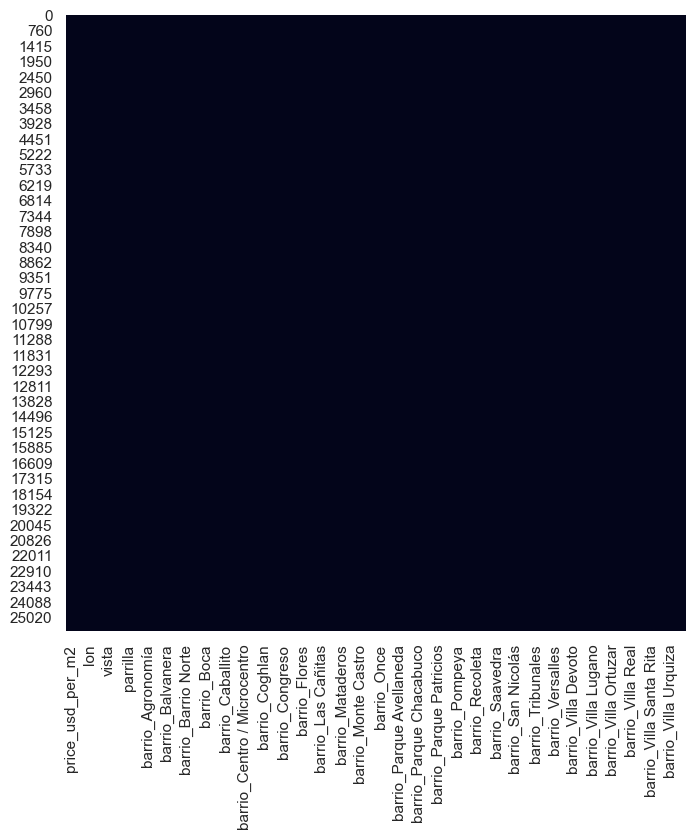

In [47]:
sns.heatmap(datos.notnull(),cbar=False)
#Seteamos el tamaño de nuestro plot
sns.set(rc={'figure.figsize':(8,8)})

# 2- Implementación de Modelos

### Debemos realizar un análisis preliminar para determinar si las 'features' que elegimos como predictoras tienen relación con el precio por metro cuadrado

Primero podemos utilizar correlaciones, scatterplot y regresión lineal simple para determinar cuales son las mejores variables predictoras.

Para una mayor facilidad de lectura, primero veremos las relaciones entre las variables sin tener en cuenta las dummies de lo barrios.

## 2.1 Análisis de Variables mediante gráficos

In [48]:
### Primero ver correlación pair plot entre variables

# sns.heatmap(advertising.corr(), annot=True, vmin=-1, cmap='Blues');

#Creo un nuevo df con las variables que quiero analizar
datos_filtro=datos[['price_usd_per_m2','lat','lon','surface_total_in_m2']]

### Utilizamos la matriz de correlaciones para ver si alguna de estas features tiene valor predictivo para el target

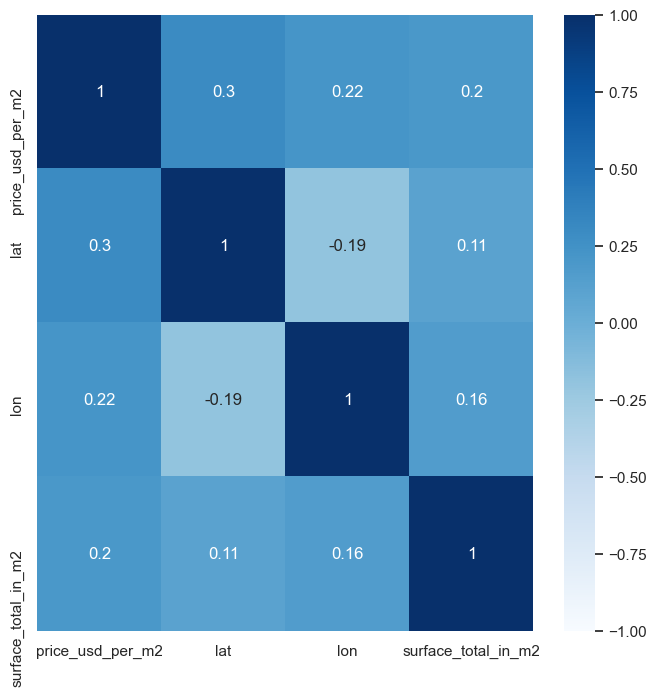

In [49]:

sns.heatmap(datos_filtro.corr(), annot=True, vmin=-1, cmap='Blues');
sns.set(rc={'figure.figsize':(8,8)})

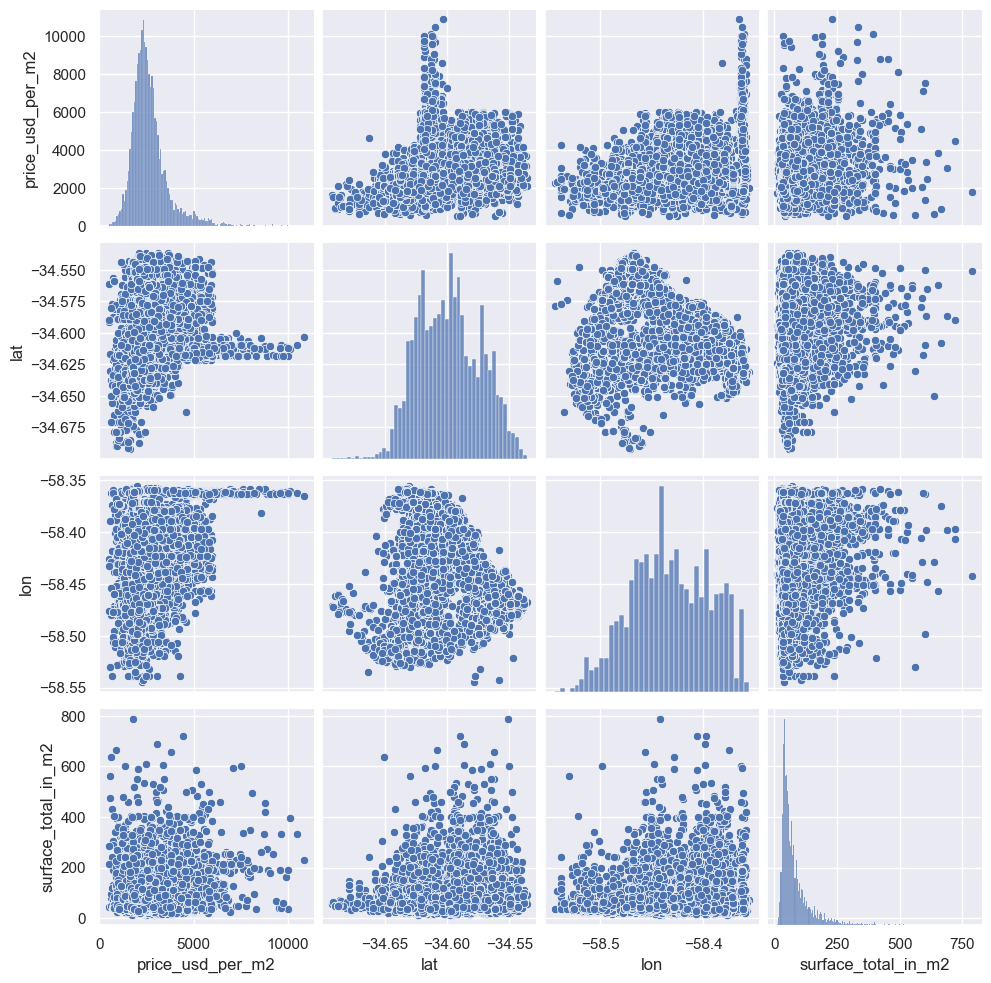

In [50]:
#Repetimos el análisis utilizando el grafico pairplot
sns.pairplot(datos_filtro);

## 2.1 Análisis de Variables mediante regresión lineal simple

Probamos la regresión lineal simple con price_usd_per_m2 y otras variables

### 2.1.a Gráfico de Regresión lineal entre superficie total y precio por metro cuadrado

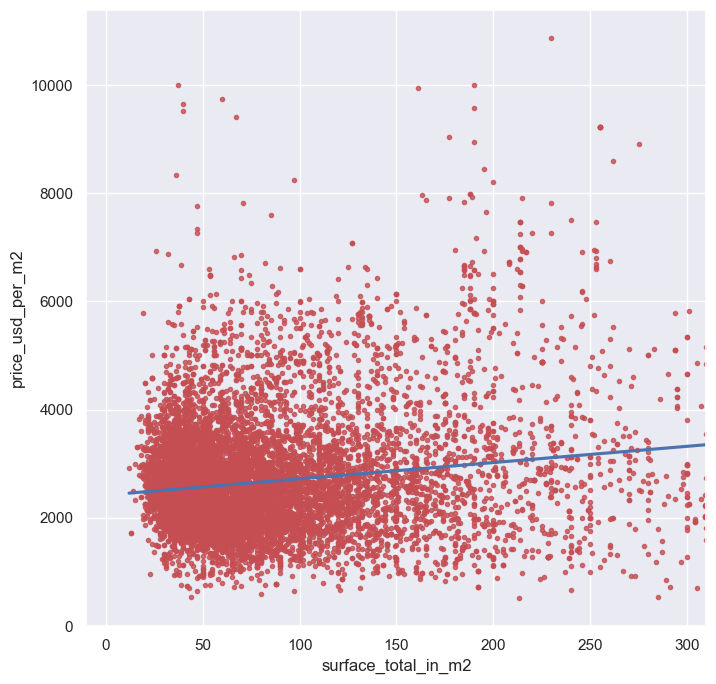

In [51]:
#Modelo para superficie total
sns.regplot(data = datos, x="surface_total_in_m2", y="price_usd_per_m2", order=1, ci=None, scatter_kws={'color':'r', 's':9})
plt.xlim(-10,310)
plt.ylim(bottom=0);

### 2.1.b Gráfico de Regresión lineal entre latitud y precio por metro cuadrado

<AxesSubplot:xlabel='lon', ylabel='price_usd_per_m2'>

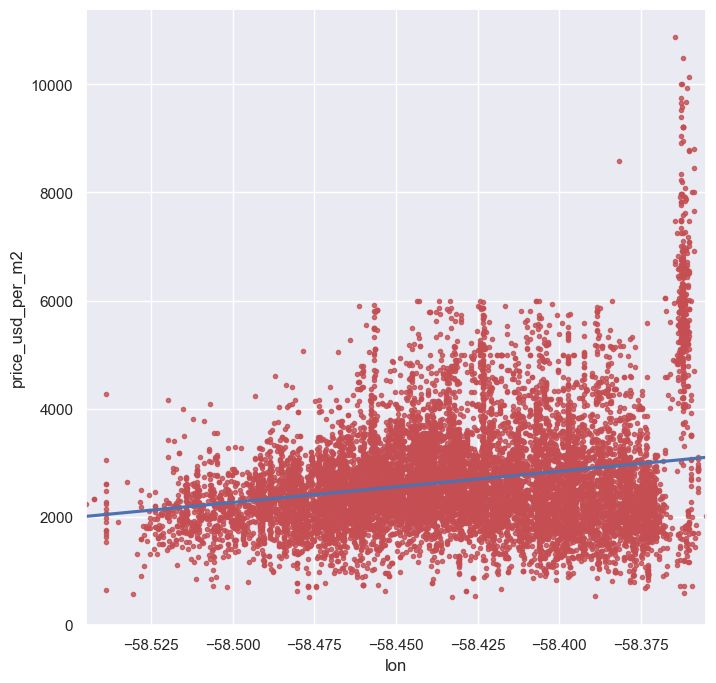

In [52]:
#Modelo para superficie total
sns.regplot(data = datos, x="lon", y="price_usd_per_m2", order=1, ci=None, scatter_kws={'color':'r', 's':9})
#plt.xlim(-10,310)
#plt.ylim(bottom=0);

### 2.1.c Gráfico de Regresión lineal entre longitud y precio por metro cuadrado

<AxesSubplot:xlabel='lat', ylabel='price_usd_per_m2'>

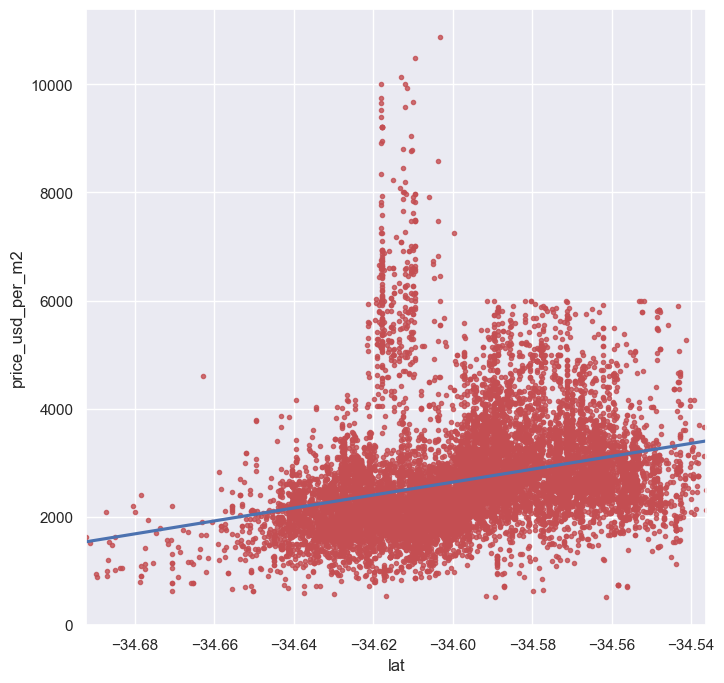

In [53]:
sns.regplot(data = datos, x="lat", y="price_usd_per_m2", order=1, ci=None, scatter_kws={'color':'r', 's':9})

Ninguna de las tres variables tiene una fuerte lineanidad. Los puntos estan muy dispersos de la recta.

Vemos que hay una latitud y longitud asociadas a precios muchos mas altos. Revisando los mapas, podemos ver que pertenece al barrio de Puerto Madero.

Repetimos el análisis de lat y lon, luego de filtrar el barrio Puerto Madero.

In [54]:
#Que pasa si dropeamos Puero Madero y repetimos el análisis para lon y lat
mask_sin_PM=datos.loc[datos['barrio_Puerto Madero']==1]
caba_sin_PM=datos.drop(mask_sin_PM.index,axis=0)

### 2.1.b* Gráfico de Regresión lineal entre latitud y precio por metro cuadrado ( sin Puerto Madero)

<AxesSubplot:xlabel='lat', ylabel='price_usd_per_m2'>

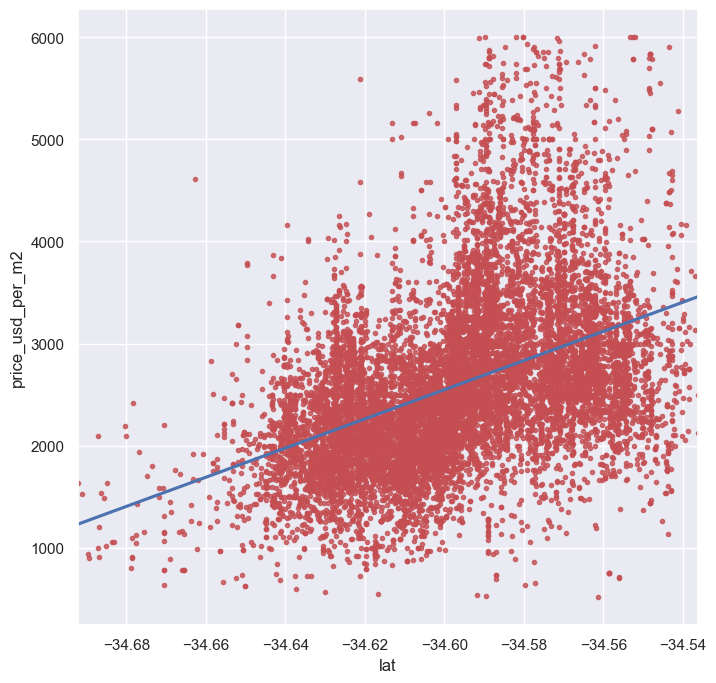

In [55]:
sns.regplot(data = caba_sin_PM, x="lat", y="price_usd_per_m2", order=1, ci=None, scatter_kws={'color':'r', 's':9})

### 2.1.c* Gráfico de Regresión lineal entre longitud y precio por metro cuadrado ( sin Puerto Madero)

<AxesSubplot:xlabel='lon', ylabel='price_usd_per_m2'>

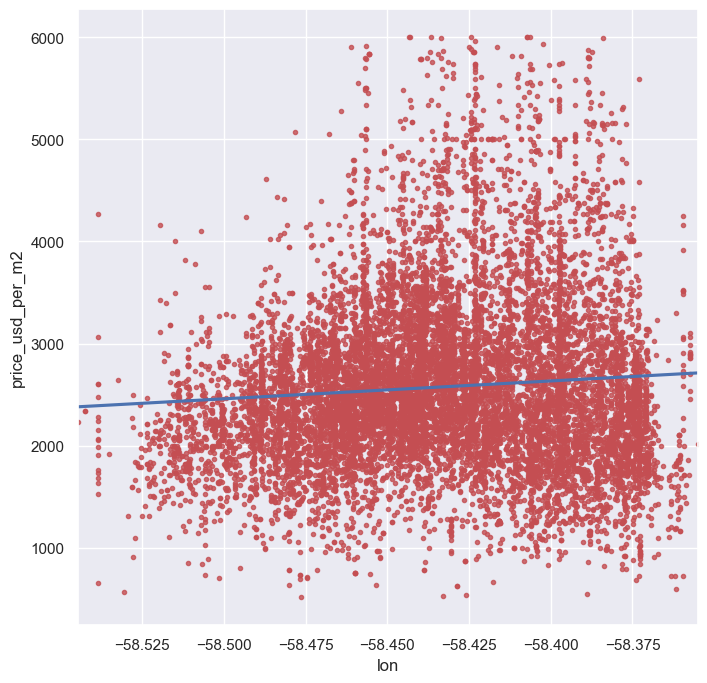

In [56]:
sns.regplot(data = caba_sin_PM, x="lon", y="price_usd_per_m2", order=1, ci=None, scatter_kws={'color':'r', 's':9})

### Aun retirando PM, lat y lon no tiene tanta relación lineal con el precio por metro 2

## 2.2 Análisis de Variables mediante modelos de regresión lineal simple

COmo vamos a implementar modelos de regresión lineal, no puedo tener valores nulos en las features que quiero utilizar

### 2.2.1 Modelo de regresión lineal para variable latitud

In [57]:
#Instancio un modelo para lat
model_lat = LinearRegression(fit_intercept=True)

# Creamos X e y
feature_cols = ['lat']
X = datos[feature_cols]
y = datos.price_usd_per_m2

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

model_lat.fit(Xtrain, ytrain)

print('El coeficiente del modelo de lat es:',model_lat.coef_)

print('El intercepto del modelo de lat es:',model_lat.intercept_)

ypred = model_lat.predict(Xtest)

print('Los resultados para el modelo de lat son:')
print ('MAE:', mean_absolute_error(ytest, ypred).round(2))
print ('MSE:', mean_squared_error(ytest, ypred).round(2))
print ('RMSE:', np.sqrt(mean_squared_error(ytest, ypred)).round(2))
print ('R2:', r2_score(ytest, ypred).round(2))

El coeficiente del modelo de lat es: [12145.70168745]
El intercepto del modelo de lat es: 422887.6808004056
Los resultados para el modelo de lat son:
MAE: 628.84
MSE: 909512.05
RMSE: 953.68
R2: 0.08


El resultado fue un R2 de 0.21 lo cual es muy bajo como variable predictora.

### 2.2.2 Modelo de regresión lineal para variables latitud y longitud juntas 

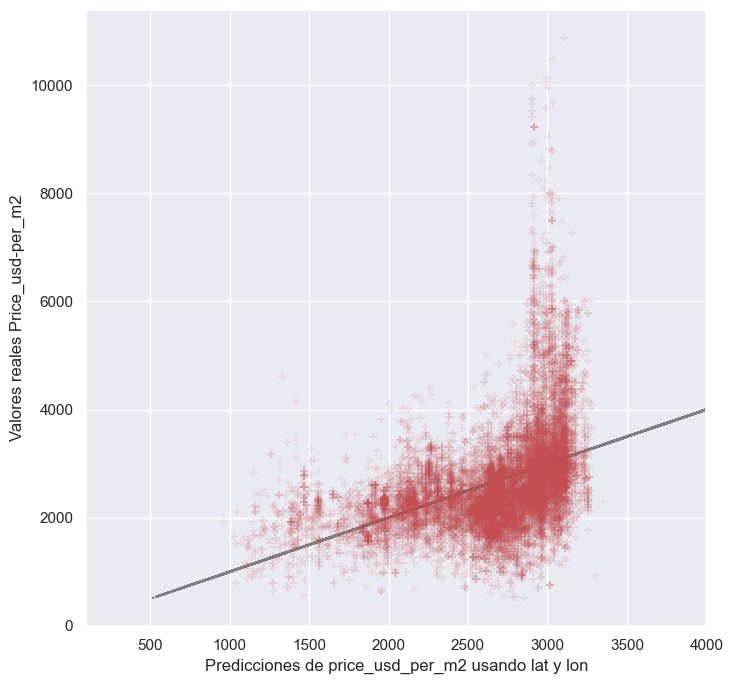

EMC: 802115.6459321445


In [58]:
# Instancio el modelo.
model_lat_lon = LinearRegression()

X = datos[["lat", "lon"]]
y = datos["price_usd_per_m2"]

# Fiteo el modelo y hago las predicciones.
model = model_lat_lon.fit(X, y)
predictions = model.predict(X)

# Graficamos el modelo
plt.rcParams['figure.figsize'] = 8,8


plt.plot(y,y, '-.',c='grey')
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10,alpha=0.1)
plt.xlabel("Predicciones de price_usd_per_m2 usando lat y lon")
plt.ylabel("Valores reales Price_usd-per_m2")
plt.xlim(100,4000)
plt.show()
print ("EMC:", mean_squared_error(y, predictions))


In [59]:

def sum_mod(model, X):
    a = pd.DataFrame(model.coef_ , X.columns.values)
    a = a.append(pd.DataFrame([model.intercept_, model.score(X, y)], index=['Intecept','R2']))
    return(a)


sum_mod(model_lat_lon, X)

,0
lat,14190.468147
lon,7544.434443
Intecept,934465.227399
R2,0.173223


El R2 mejoro pero es casi despreciable la diferencia de 0,01.

### 2.2.3 Modelo de regresión lineal para variables latitud, longitud y superficie total juntas 

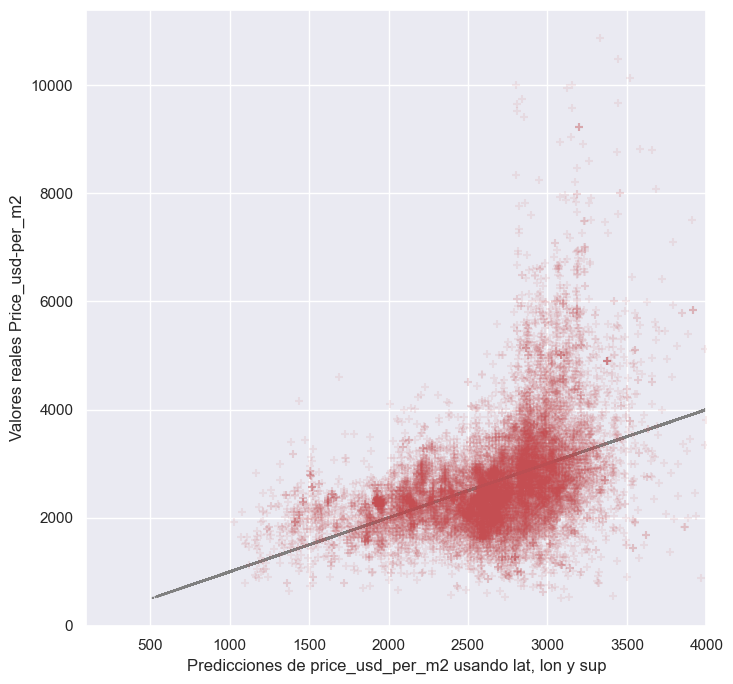

EMC: 789869.934064159


In [60]:
# Instancio el modelo.
model_lat_lon_sup = LinearRegression()

#Usamos los datos filtrados para lat y lon, ya que la columna de superficie no tiene nulos
X = datos[["lat", "lon","surface_total_in_m2"]]
y = datos["price_usd_per_m2"]

# Fiteo el modelo y hago las predicciones.
model = model_lat_lon_sup.fit(X, y)
predictions = model.predict(X)

# Graficamos el modelo
plt.plot(y,y, '-.',c='grey')
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10,alpha=0.1)
plt.xlabel("Predicciones de price_usd_per_m2 usando lat, lon y sup")
plt.ylabel("Valores reales Price_usd-per_m2")
plt.xlim(100,4000)
plt.show()
print ("EMC:", mean_squared_error(y, predictions))

# Mismo analisis con stats model

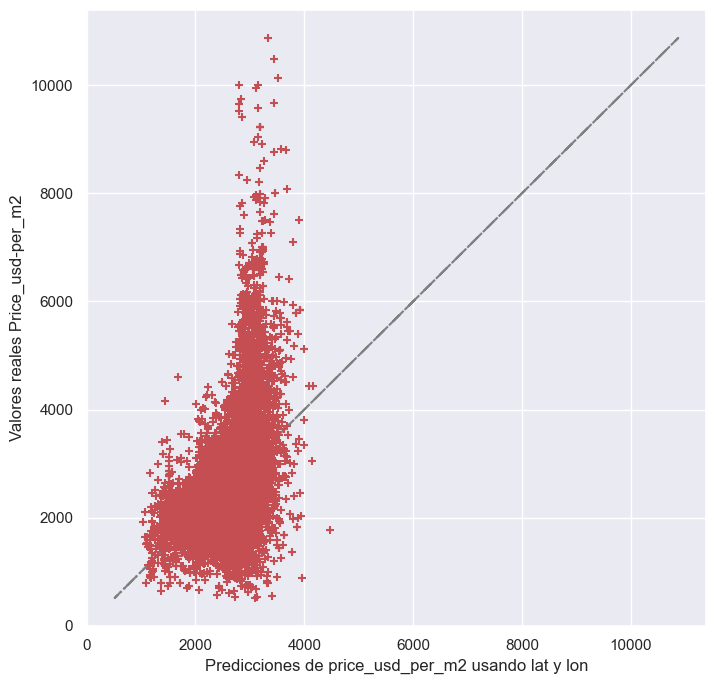

EMC: 789869.934064159


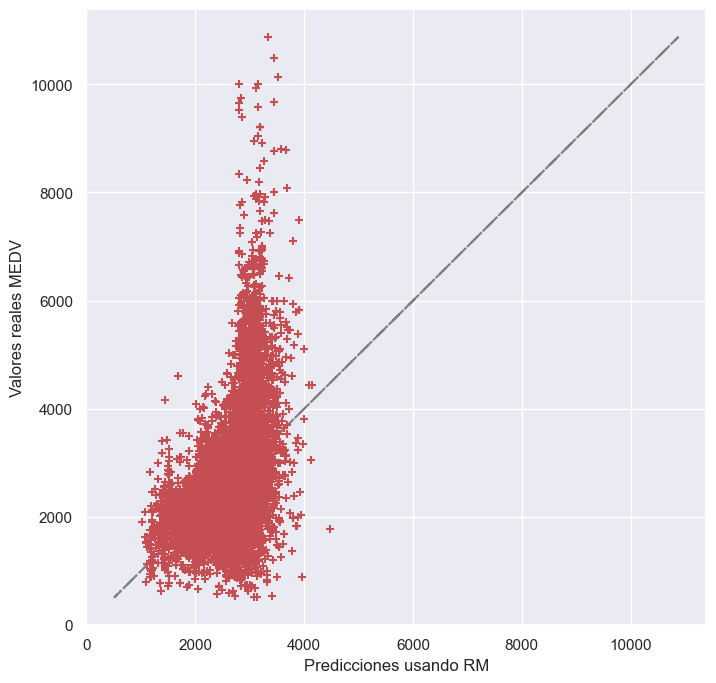

EMC: 789869.9340641566
                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     1074.
Date:                Wed, 30 Nov 2022   Prob (F-statistic):               0.00
Time:                        15:55:09   Log-Likelihood:            -1.1593e+05
No. Observations:               14123   AIC:                         2.319e+05
Df Residuals:                   14119   BIC:                         2.319e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const      

In [61]:
# Importamos la api.
import statsmodels.api as sm

# De manera análoga a la vista en el primer ejercicio, definimos el vector de variables con la primer variable RM.
# Instancio el modelo.
#model_lat_lon = linear_model.LinearRegression()

X = datos[["lat", "lon","surface_total_in_m2"]]
y = datos["price_usd_per_m2"]

# Fiteo el modelo y hago las predicciones.
model = model_lat_lon.fit(X, y)
predictions = model.predict(X)

# Graficamos el modelo
plt.plot(y,y, '-.',c='grey')
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones de price_usd_per_m2 usando lat y lon")
plt.ylabel("Valores reales Price_usd-per_m2")
plt.show()
print ("EMC:", mean_squared_error(y, predictions))
prevMSE = mean_squared_error(y, predictions)
# Tenemos que agregar explícitamente a una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Graficamos los resultados
plt.plot(y,y, '-.', c='grey')
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones usando RM")
plt.ylabel("Valores reales MEDV")
plt.show()

# Imprimimos el MSE y un resumen del modelo
print ("EMC:", mean_squared_error(y, predictions))
print (model.summary())

# Modelo utilizando las variables Dummies de Barrios

In [62]:
feature_barrios=datos.columns
feature_barrios=feature_barrios.drop('price_usd_per_m2')

In [63]:
feature_cols = feature_barrios
X = datos[feature_cols]
y = datos.price_usd_per_m2
linreg = LinearRegression()
linreg.fit(X, y)


list(zip(feature_cols, linreg.coef_))

[('lat', 12228.128475095156),
 ('lon', 6677.933491131532),
 ('surface_total_in_m2', -0.401832151008648),
 ('vista', 58.319884962451056),
 ('pileta', 420.67188761985153),
 ('parrilla', -3.2800673582686386),
 ('cochera', 174.8390059215768),
 ('barrio_Agronomía', 32.15402674983448),
 ('barrio_Almagro', -14.319713439032284),
 ('barrio_Balvanera', -383.00126162748984),
 ('barrio_Barracas', -220.55337718778333),
 ('barrio_Barrio Norte', 373.1532863845632),
 ('barrio_Belgrano', 342.72042479067386),
 ('barrio_Boca', -714.1415783249188),
 ('barrio_Boedo', -111.06015450512905),
 ('barrio_Caballito', 383.3581043166919),
 ('barrio_Catalinas', -694.0920039177853),
 ('barrio_Centro / Microcentro', -274.9620905402443),
 ('barrio_Chacarita', -64.16330837983195),
 ('barrio_Coghlan', -21.908999035716022),
 ('barrio_Colegiales', 78.541649013529),
 ('barrio_Congreso', -401.4998011827008),
 ('barrio_Constitución', -537.5008272606814),
 ('barrio_Flores', 264.665625197998),
 ('barrio_Floresta', 373.529510823

In [64]:
import statsmodels.api as sm

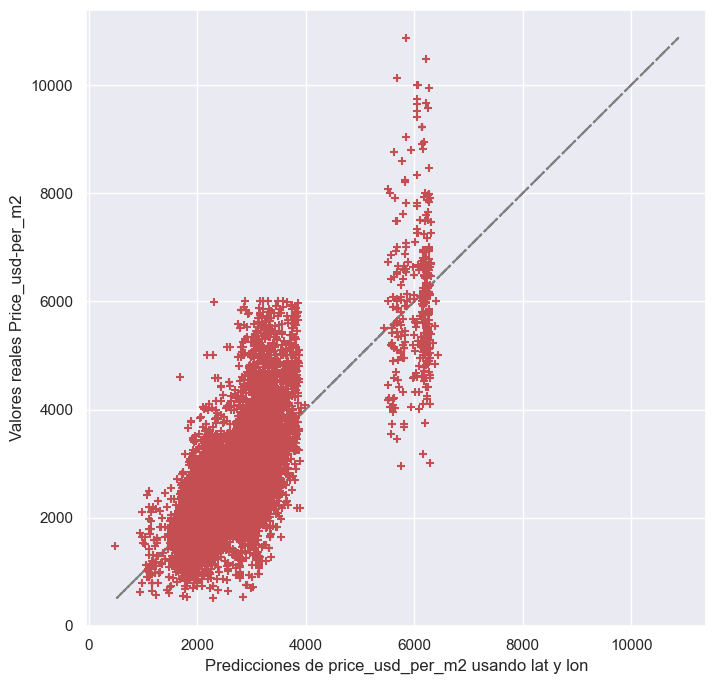

EMC: 397862.7599147001


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [65]:
# Importamos la api.
#import statsmodels.api as sm

# De manera análoga a la vista en el primer ejercicio, definimos el vector de variables con la primer variable RM.
# Instancio el modelo.
model_barrios = LinearRegression()

feature_cols = feature_barrios
X = datos[feature_cols]
y = datos.price_usd_per_m2


# Fiteo el modelo y hago las predicciones.
model = model_barrios.fit(X, y)
predictions = model.predict(X)

# Graficamos el modelo
plt.plot(y,y, '-.',c='grey')
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones de price_usd_per_m2 usando lat y lon")
plt.ylabel("Valores reales Price_usd-per_m2")
plt.show()
print ("EMC:", mean_squared_error(y, predictions))
prevMSE = mean_squared_error(y, predictions)
# Tenemos que agregar explícitamente a una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Graficamos los resultados
plt.plot(y,y, '-.', c='grey')
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones usando RM")
plt.ylabel("Valores reales MEDV")
plt.show()

# Imprimimos el MSE y un resumen del modelo
print ("EMC:", mean_squared_error(y, predictions))
print (model.summary())

### OLS

In [89]:
X = datos.drop(columns=['price_usd_per_m2'])
y = datos['price_usd_per_m2']
X_train, X_test, y_train, y_test = train_test_split(X, y)


In [109]:
model_OLS = LinearRegression(fit_intercept=True)
model_OLS.fit(X_train, y_train)
predictions_train_OLS = model_OLS.predict(X_train)
predictions_test_OLS = model_OLS.predict(X_test)

print('Resultados del entrenamiento - OLS')
print(f'r2: {model_OLS.score(X_train, y_train)}')
print(f'MSE: {mean_squared_error(y_train, predictions_train_OLS)}', '\n')

print('Resultado del test - OLS')
print(f'r2: {model_OLS.score(X_test, y_test)}')
print(f'MSE: {mean_squared_error(y_test, predictions_test_OLS)}', '\n')


Resultados del entrenamiento - OLS
r2: 0.5917632402768112
MSE: 392785.8477233731 

Resultado del test - OLS
r2: 0.5823526911288435
MSE: 415236.1251000332 



### Ridge

In [103]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

In [111]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
model_ridge_cv = RidgeCV(alphas = [ 0.001, 0.01, 0.1, 0.3, 0.5, 1.0, 1.1, 1.15, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.3, 1.4, 1.5, 10.0],
                    fit_intercept=True, cv=10)
model_ridge_cv.fit(X_train_std, y_train)
print(model_ridge_cv.alpha_)

predictions_train_ridge = model_ridge_cv.predict(X_train_std)
predictions_test_ridge = model_ridge_cv.predict(X_test_std)

print('Resultados del entrenamiento - Ridge')
print(f'r2: {model_ridge_cv.score(X_train_std, y_train)}')
print(f'MSE: {mean_squared_error(y_train, predictions_train_ridge)}', '\n')

print('Resultado del test - Ridge')
print(f'r2: {model_ridge_cv.score(X_test_std, y_test)}')
print(f'MSE: {mean_squared_error(y_test, predictions_test_ridge)}', '\n')

10.0
Resultados del entrenamiento - Ridge
r2: 0.5917555641401927
MSE: 392793.23333419097 

Resultado del test - Ridge
r2: 0.5824047774695367
MSE: 415184.33946698665 



### Lasso

In [114]:
model_lasso_cv = LassoCV(alphas = [ 0.001, 0.01, 0.1, 0.3, 0.5, 1.0, 1.1, 1.15, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.3, 1.4, 1.5, 10.0],
                    fit_intercept=True, cv=10)
model_lasso_cv.fit(X_train_std, y_train)
print(model_lasso_cv.alpha_)

predictions_train_lasso = model_lasso_cv.predict(X_train_std)
predictions_test_lasso = model_lasso_cv.predict(X_test_std)

print('Resultados del entrenamiento - Lasso')
print(f'r2: {model_lasso_cv.score(X_train_std, y_train)}')
print(f'MSE: {mean_squared_error(y_train, predictions_train_lasso)}', '\n')

print('Resultado del test - Lasso')
print(f'r2: {model_lasso_cv.score(X_test_std, y_test)}')
print(f'MSE: {mean_squared_error(y_test, predictions_test_lasso)}', '\n')

0.1
Resultados del entrenamiento - Lasso
r2: 0.5917555349323049
MSE: 392793.2614366211 

Resultado del test - Lasso
r2: 0.5824041236009365
MSE: 415184.9895606375 



### Con Statmodels

In [194]:
datos['vista'] = datos['vista'].astype(float)
datos['pileta'] = datos['pileta'].astype(float)
datos['parrilla'] = datos['parrilla'].astype(float)
datos['cochera'] = datos['cochera'].astype(float)

In [199]:
import statsmodels.api as sm
X_s = datos.drop(columns=['price_usd_per_m2'])
y_s = datos['price_usd_per_m2']
X_s = sm.add_constant(X_s)
model = sm.OLS(y_s, X_s).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     326.2
Date:                Wed, 30 Nov 2022   Prob (F-statistic):               0.00
Time:                        19:43:30   Log-Likelihood:            -1.1109e+05
No. Observations:               14123   AIC:                         2.223e+05
Df Residuals:                   14060   BIC:                         2.228e+05
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             